<a href="https://colab.research.google.com/github/AJH0625/CV-study/blob/main/%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
  -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-07-11 06:46:56--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.20.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   135MB/s    in 0.6s    

2021-07-11 06:46:57 (135 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top = False,
                                weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output.shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [11]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-07-11 07:16:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  37.8MB/s    in 1.7s    

2021-07-11 07:16:11 (37.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255.,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  target_size=(150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_steps=50,
    verbose=2
)

Epoch 1/20
100/100 - 50s - loss: 1.4226 - accuracy: 0.8370 - val_loss: 0.1801 - val_accuracy: 0.9380
Epoch 2/20
100/100 - 17s - loss: 0.2869 - accuracy: 0.9070 - val_loss: 0.2951 - val_accuracy: 0.9230
Epoch 3/20
100/100 - 17s - loss: 0.3179 - accuracy: 0.8995 - val_loss: 0.1177 - val_accuracy: 0.9560
Epoch 4/20
100/100 - 17s - loss: 0.2442 - accuracy: 0.9205 - val_loss: 0.3078 - val_accuracy: 0.9150
Epoch 5/20
100/100 - 17s - loss: 0.2656 - accuracy: 0.9090 - val_loss: 0.0950 - val_accuracy: 0.9630
Epoch 6/20
100/100 - 17s - loss: 0.2120 - accuracy: 0.9285 - val_loss: 0.1069 - val_accuracy: 0.9610
Epoch 7/20
100/100 - 17s - loss: 0.1963 - accuracy: 0.9345 - val_loss: 0.1063 - val_accuracy: 0.9610
Epoch 8/20
100/100 - 17s - loss: 0.1827 - accuracy: 0.9345 - val_loss: 0.1230 - val_accuracy: 0.9600
Epoch 9/20
100/100 - 17s - loss: 0.1944 - accuracy: 0.9300 - val_loss: 0.0920 - val_accuracy: 0.9720
Epoch 10/20
100/100 - 17s - loss: 0.1669 - accuracy: 0.9405 - val_loss: 0.1108 - val_accura

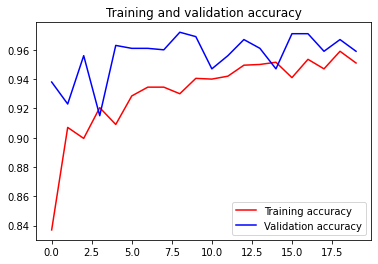

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()